In [1]:
DATA_URL = './ArtData/'

import os

In [2]:
for cls in os.listdir(DATA_URL):
  print(cls, ':', len(os.listdir(DATA_URL + '/' + cls)))

rene-magritte : 366
andre-masson : 110
salvador-dali : 1098
m-c-escher : 418
albrecht-durer : 830


In [3]:
from torchvision.datasets import ImageFolder

In [4]:
DATASET = ImageFolder(DATA_URL)

In [5]:
len(DATASET)

2822

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline


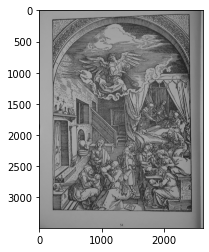

In [8]:
IMG, LABEL = DATASET[0]
plt.imshow(IMG)

In [9]:
IMG, LABEL = DATASET[555]

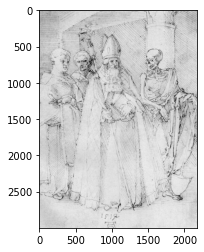

In [10]:
plt.imshow(IMG)

In [11]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader

In [12]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(DATA_URL, transform=tt.Compose([
    tt.Resize(IMAGE_SIZE),
    tt.CenterCrop(IMAGE_SIZE),
    tt.ToTensor(),
    tt.Normalize(*STATS)]))

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

In [14]:
from torchvision.utils import make_grid


In [15]:

def denorm(_imgTensors):
    return _imgTensors * STATS[1][0] + STATS[0][0]

In [16]:
def show_images(_images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(_images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

In [17]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

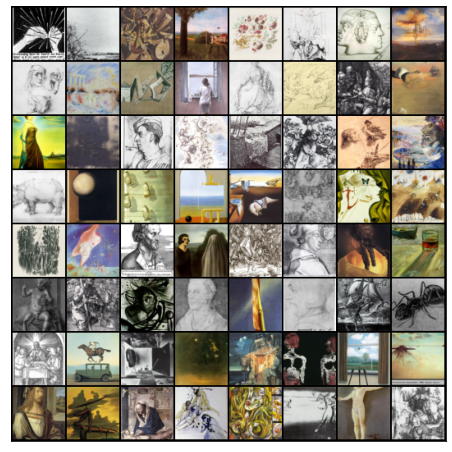

In [18]:
show_batch(train_dl)


In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
import torch


In [21]:
device = get_default_device()
device

device(type='cpu')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)


In [23]:
import torch.nn as nn


In [24]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [25]:
discriminator = to_device(discriminator, device)


In [28]:
LATENT_SIZE = 128



generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


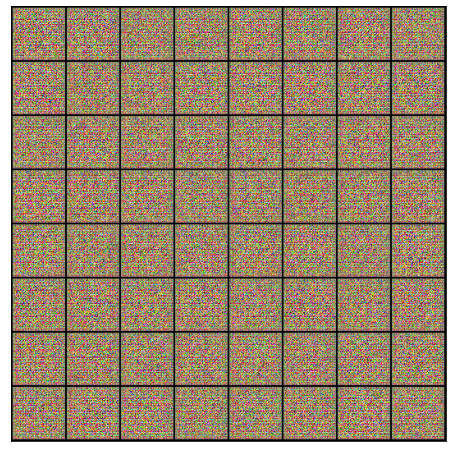

In [29]:

xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [30]:
generator = to_device(generator, device)


In [31]:

def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [32]:

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [33]:
from torchvision.utils import save_image


In [34]:
SAMPLE_DIR = 'ganArt'
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [35]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [37]:
FIXED_LATENT = torch.randn(64, LATENT_SIZE, 1, 1, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


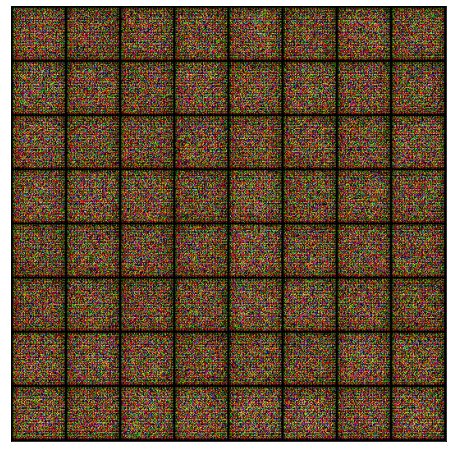

In [38]:
save_samples(0, FIXED_LATENT)


In [39]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [40]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, FIXED_LATENT, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [41]:

LEARNING_RATE = 0.0002
EPOCHS = 400

In [ ]:
history = fit(EPOCHS, LEARNING_RATE)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [1/400], loss_g: 10.3088, loss_d: 2.2169, real_score: 0.8310, fake_score: 0.8620
Saving generated-images-0001.png


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/400], loss_g: 5.9183, loss_d: 0.6074, real_score: 0.7646, fake_score: 0.2051
Saving generated-images-0002.png


  0%|          | 0/23 [00:00<?, ?it/s]